In [289]:
!pip install pyxlsb
!pip install pandas --upgrade
!pip install openpyxl

In [290]:
import pandas as pd
import pyxlsb
import numpy as np
import matplotlib.pyplot as plt

In [291]:
dataframe = pd.read_excel('stc TV Data Set_T2.xlsb', engine='openpyxl')

In [292]:
dataframe.drop('Unnamed: 0', axis=1, inplace=True)
dataframe.head(10)

,date_,Total_watch_time_in_houres
0,2018-01-01,1123.551944
1,2018-01-02,1000.129722
2,2018-01-03,881.924444
3,2018-01-04,782.669444
4,2018-01-05,1051.939444
5,2018-01-08,841.178333
6,2018-01-09,873.495000
7,2018-01-10,970.475000
8,2018-01-11,721.381944
9,2018-01-12,772.675000


In [293]:
dataframe.tail(10)

,date_,Total_watch_time_in_houres
76,2018-04-17,750.944444
77,2018-04-18,566.104444
78,2018-04-19,586.404444
79,2018-04-20,700.296667
80,2018-04-23,670.885556
81,2018-04-24,652.625278
82,2018-04-25,650.428889
83,2018-04-26,675.184444
84,2018-04-27,601.738056
85,2018-04-30,609.281667


In [294]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date_                       86 non-null     datetime64[ns]
 1   Total_watch_time_in_houres  86 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 KB


In [295]:
dataframe.describe()

,date_,Total_watch_time_in_houres
count,86,86.000000
mean,2018-02-28 17:01:23.720930304,780.817926
min,2018-01-01 00:00:00,562.124722
25%,2018-01-30 06:00:00,707.709653
50%,2018-02-28 12:00:00,763.181389
75%,2018-03-29 18:00:00,840.985278
max,2018-04-30 00:00:00,1123.551944
std,NaN,122.992002


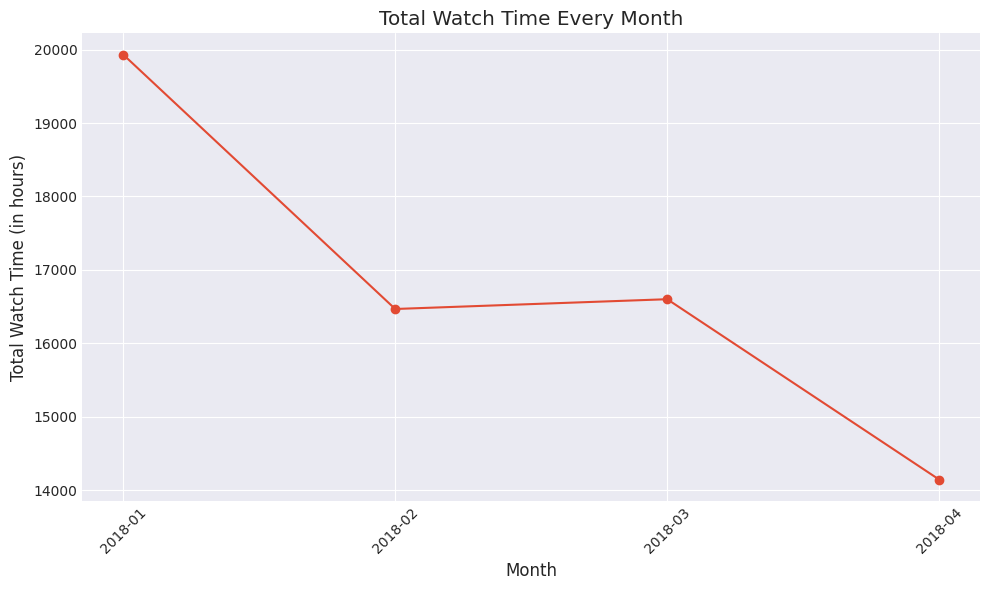

In [296]:
dataframe['date_'] = pd.to_datetime(dataframe['date_'])

# Group data by month and calculate total watch time for each month
monthly_data = dataframe.groupby(dataframe['date_'].dt.to_period('M'))['Total_watch_time_in_houres'].sum()

# Convert the index to strings for plotting
monthly_data.index = monthly_data.index.astype(str)

# Plot the data for each month
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Total Watch Time (in hours)')
plt.title('Total Watch Time Every Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

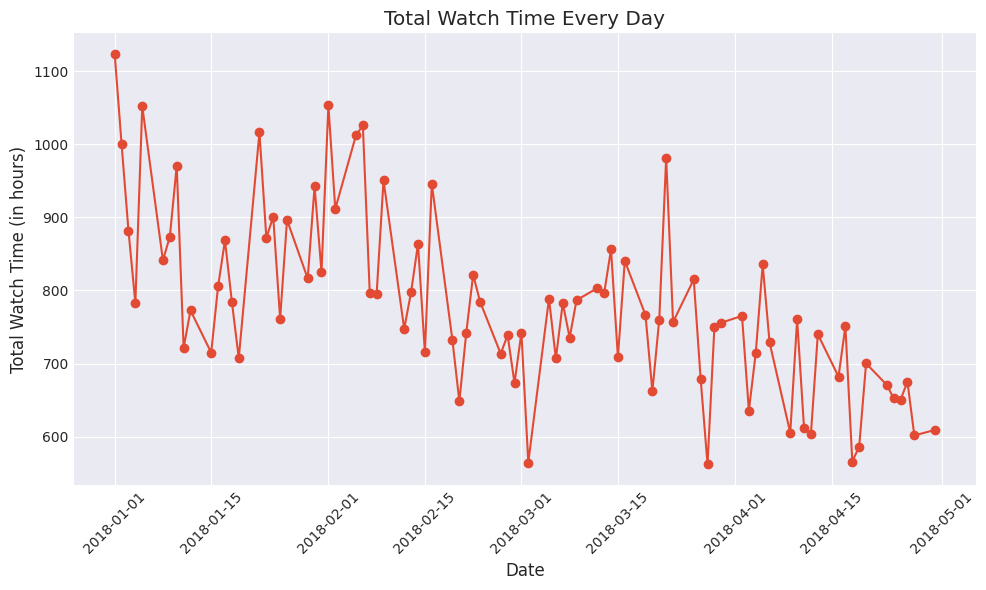

In [297]:
dataframe['date_'] = pd.to_datetime(dataframe['date_'])

# Plot the data for each day
plt.figure(figsize=(10, 6))
plt.plot(dataframe['date_'], dataframe['Total_watch_time_in_houres'], marker='o')
plt.xlabel('Date')
plt.ylabel('Total Watch Time (in hours)')
plt.title('Total Watch Time Every Day')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [298]:
from statsmodels.tsa.stattools import adfuller


data_array = np.array(dataframe['Total_watch_time_in_houres'])
result = adfuller(data_array)
test_statistic = result[0]
p_value = result[1]
significance_level = 0.05
if p_value <= significance_level:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")


The data is non-stationary (fail to reject the null hypothesis).


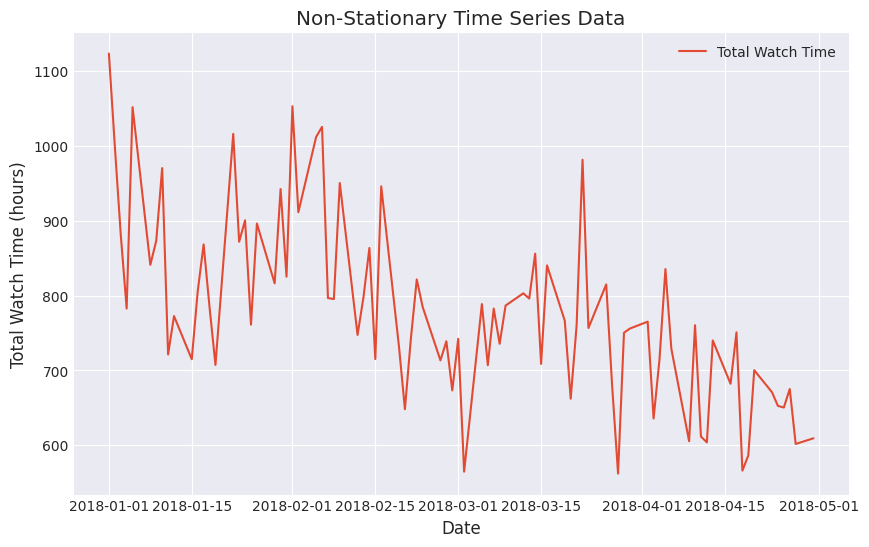

In [299]:
dataframe['date_'] = pd.to_datetime(dataframe['date_'])

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(dataframe['date_'], dataframe['Total_watch_time_in_houres'], label='Total Watch Time')
plt.xlabel('Date')
plt.ylabel('Total Watch Time (hours)')
plt.title('Non-Stationary Time Series Data')
plt.legend()
plt.grid(True)
plt.show()

In [300]:
!pip install pmdarima

In [301]:
import pmdarima as pm

# Assuming you already have your 'dataframe' loaded with the time series data

# Fit the best ARIMA model using auto_arima from pmdarima
model = pm.auto_arima(dataframe['Total_watch_time_in_houres'], start_p=0, start_q=0,
                      max_p=5, max_q=5, seasonal=False, stepwise=True, trace=True)

# Get the best values for p, d, and q
best_p, best_d, best_q = model.order

print("Best p: ", best_p)
print("Best d: ", best_d)
print("Best q: ", best_q)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1067.048, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1043.617, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1024.622, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1065.245, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1026.476, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1026.451, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1028.494, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1025.445, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.439 seconds
Best p:  0
Best d:  1
Best q:  1


In [302]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA


p, d, q = 0, 1, 1

arima_model = ARIMA(dataframe['Total_watch_time_in_houres'], order=(p, d, q))


fitted_model = arima_model.fit()


next_day = fitted_model.forecast(steps=30)

next_day_dates = pd.date_range(start='2018-05-01', periods=30)

forecast_df = pd.DataFrame(next_day, index=next_day_dates, columns=['Forecasted_Values'])



In [303]:
next_day = pd.DataFrame(next_day)
next_day.rename(columns={'predicted_mean': 'Total_watch_time_in_houres'}, inplace=True)
next_day.reset_index(drop=True, inplace=True)
next_day['date_'] = next_day_dates
first_column = next_day.pop('Total_watch_time_in_houres')
next_day['Total_watch_time_in_houres'] = first_column
concatenated_df = pd.concat([dataframe, next_day], ignore_index=True)


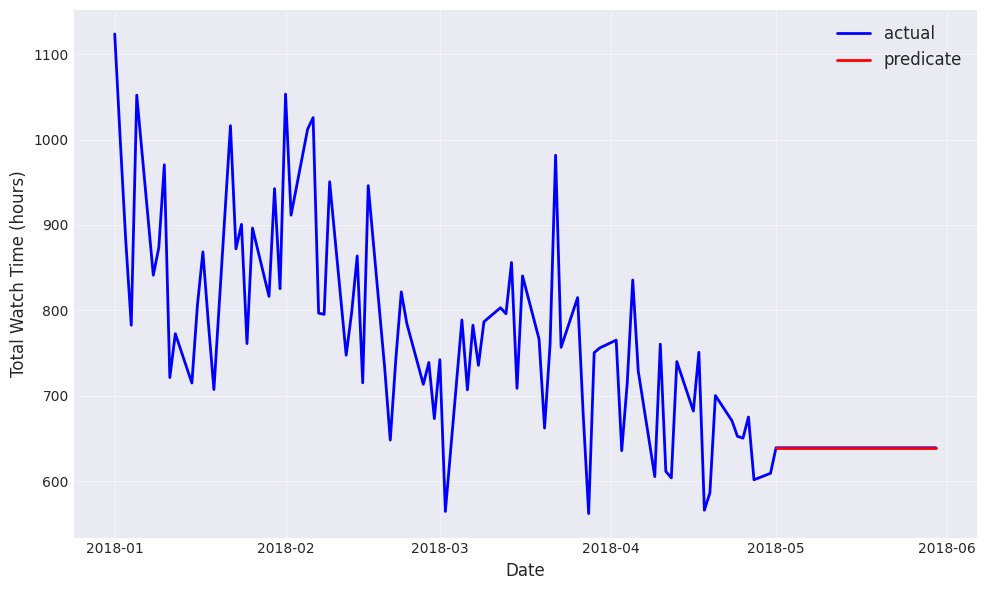

In [304]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
concatenated_df['date_'] = pd.to_datetime(concatenated_df['date_'])
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
plt.plot(concatenated_df['date_'], concatenated_df['Total_watch_time_in_houres'],
         label='actual', color='blue', linewidth=2)
plt.plot(concatenated_df.loc[highlighted_mask, 'date_'], concatenated_df.loc[highlighted_mask, 'Total_watch_time_in_houres'],
         label='predicate', color='red', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Watch Time (hours)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()
